<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-08-04 08:16:45--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.1s    

2021-08-04 08:16:46 (228 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



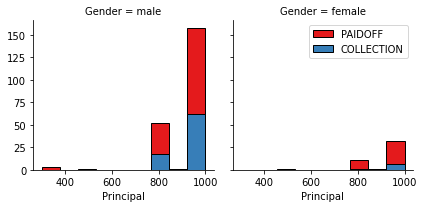

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

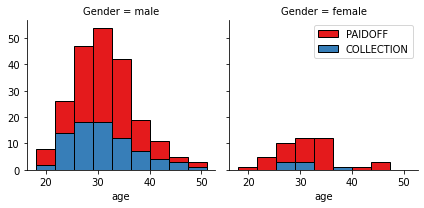

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


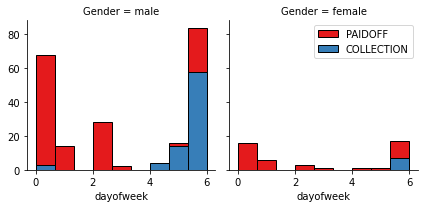

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
#Predict on the loan_train.csv's test set 
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [22]:
#accuracy evaluation on the loan_train.csv's dataset 
#metrics.accuracy_score function the same as the jaccard index

from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.6857142857142857


In [23]:
#Iterate through different Ks to get the best K value
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))


for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

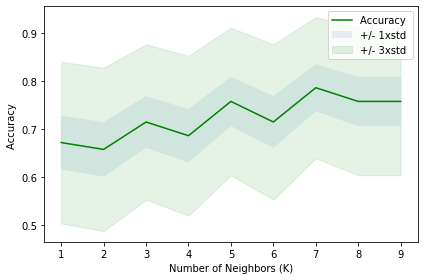

In [24]:
#plot the model accuracy of different Ks 
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

 **From the graph above, we observed that K=7 is the best value which produces the highest accuracy for the loan_train.csv dataset.** 

# Decision Tree


In [25]:
#Modeling, create an instance of the DecisionTreeClassifier called loantree
from sklearn.tree import DecisionTreeClassifier
loantree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loantree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [26]:
# fit the data with the training feature matrix X_train and training response vector y_train
loantree.fit(X_train,y_train)
#prediction on X_test set
predtree = loantree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predtree))


DecisionTrees's Accuracy:  0.6142857142857143


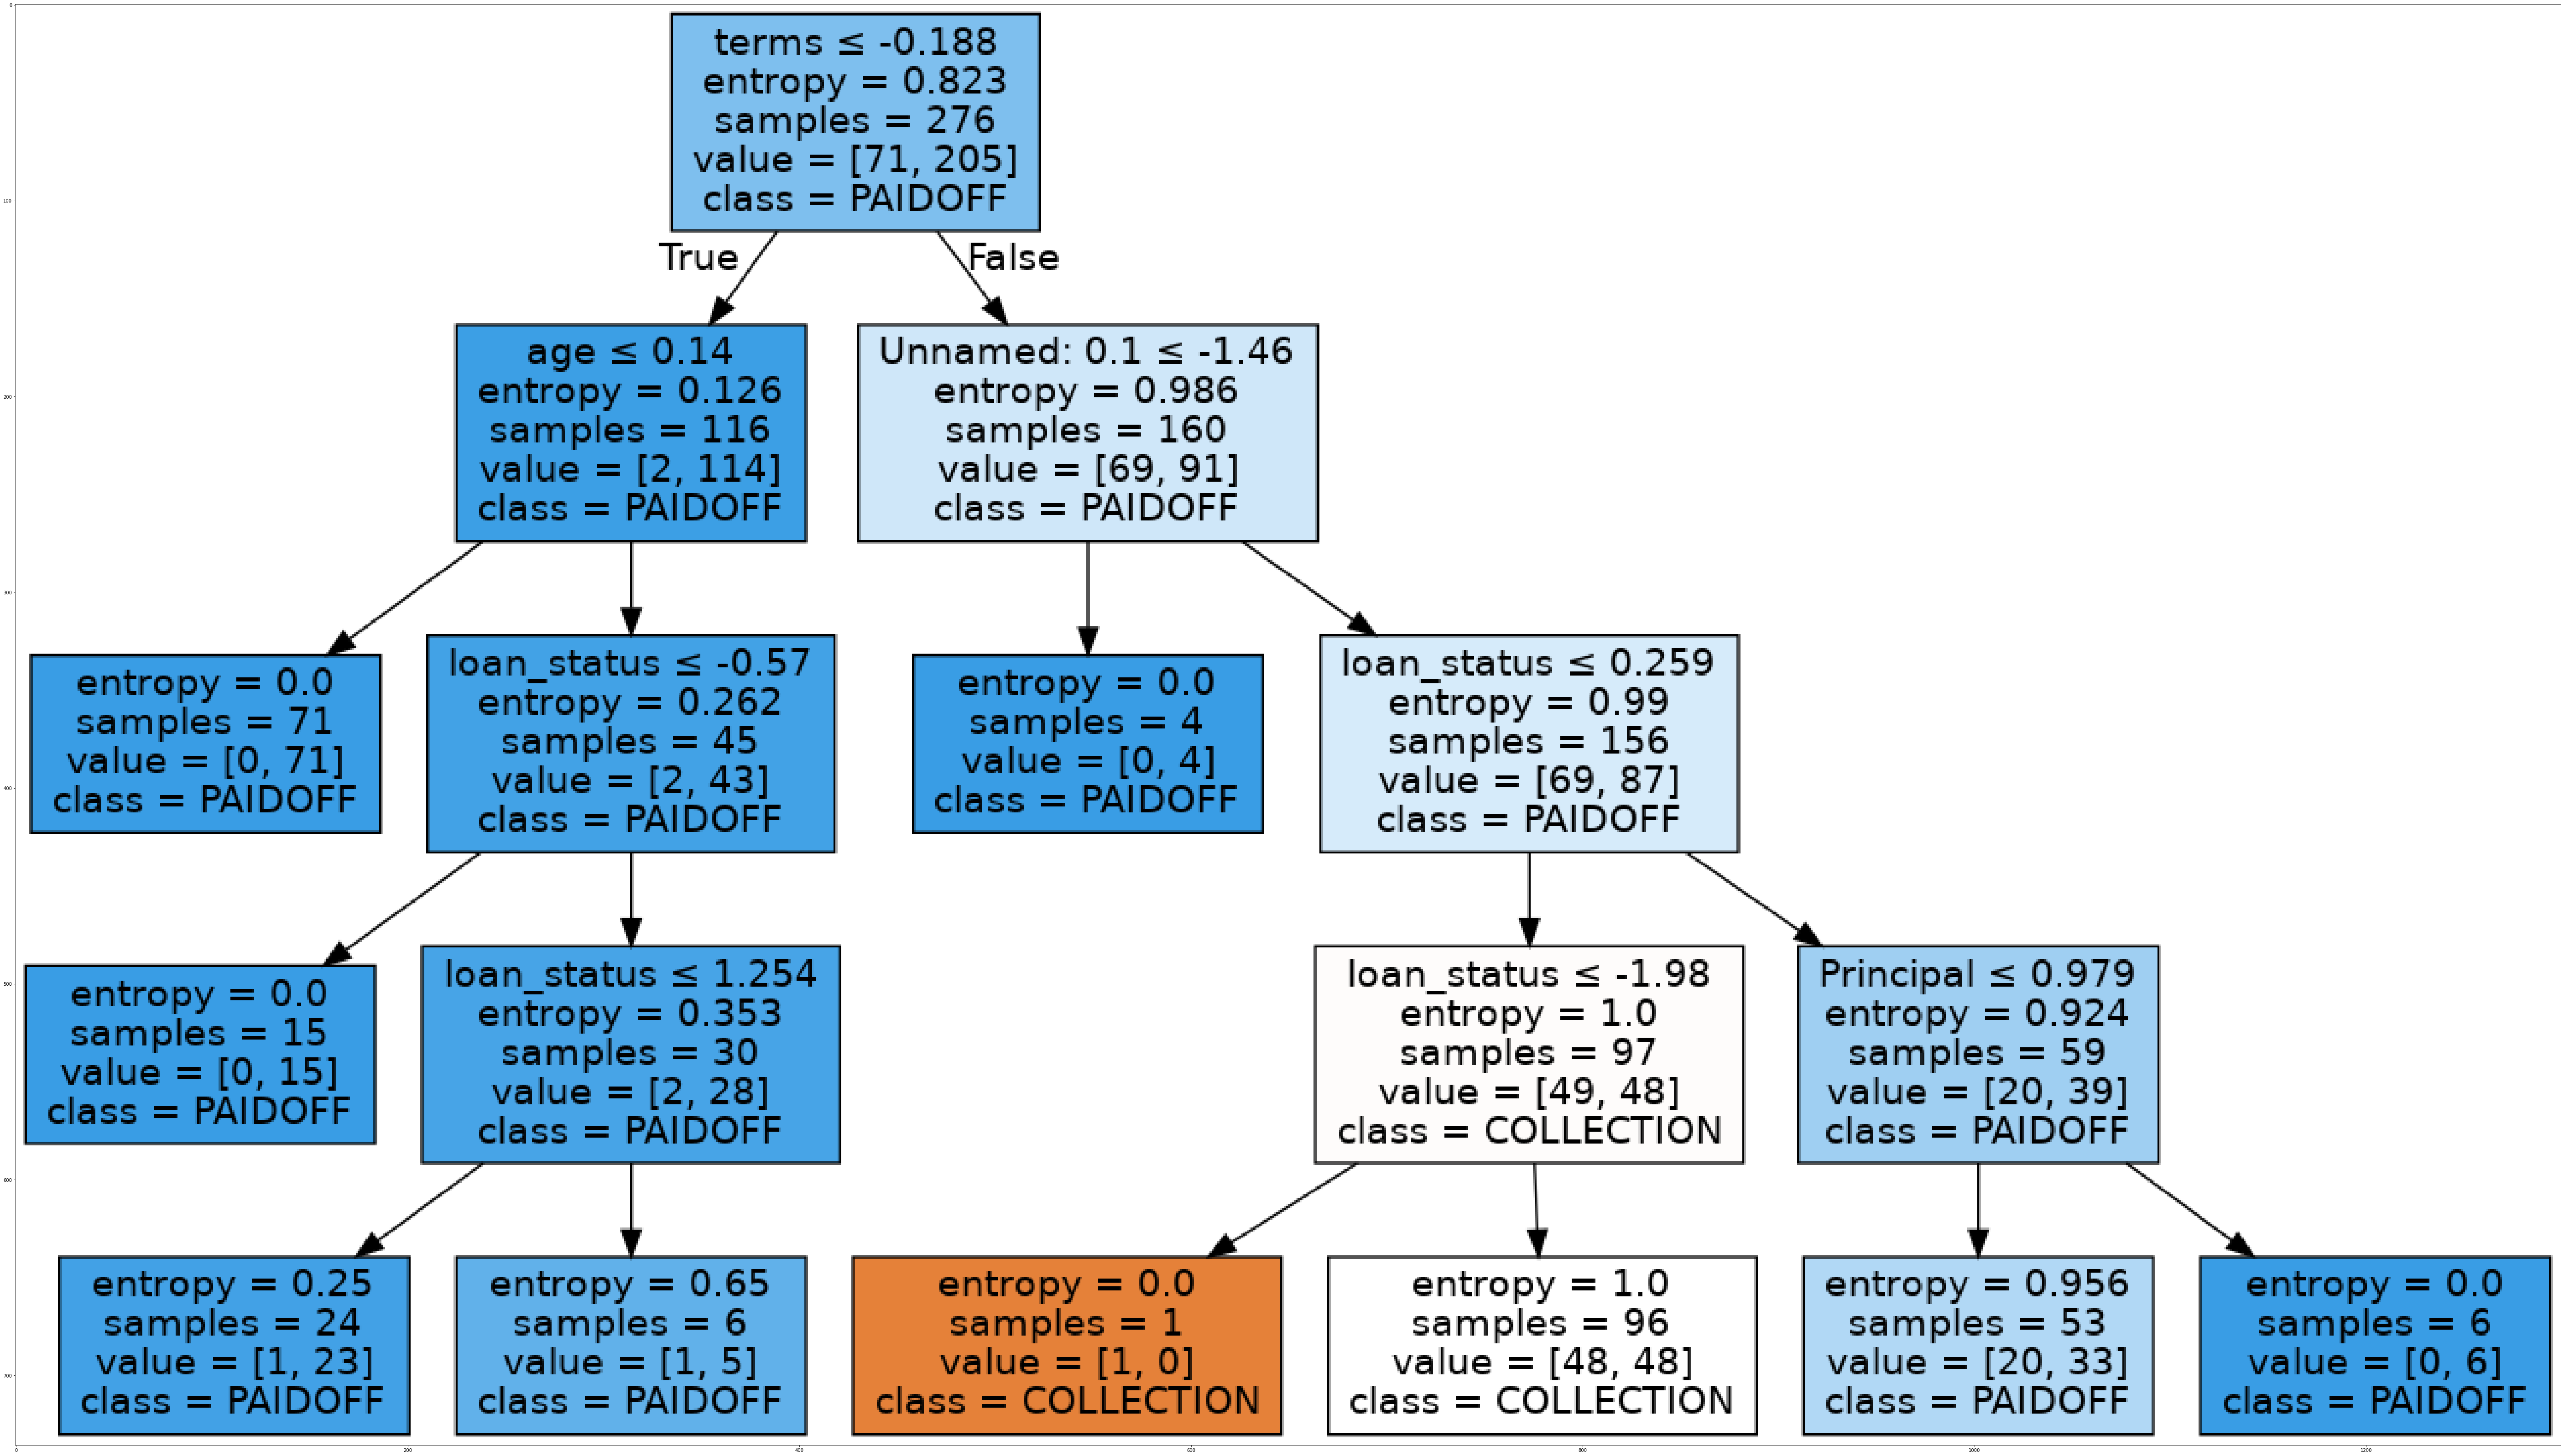

In [27]:
#Visualization 
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

loan_data = StringIO()
filename = "loantree.png"
featureNames = df.columns[0:8]
out=tree.export_graphviz(loantree,feature_names=featureNames, out_file=loan_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(loan_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [28]:
#Modeling
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

#loop through different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
#Modeling
for kernel in kernels:
    clf = svm.SVC(kernel = kernel)
    clf.fit(X_train, y_train)
    #prediction
    yhat = clf.predict(X_test)
    #Evaluation to find the best fitted kernel
    print("{} as kernel".format(kernel))
    print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
    print("Jaccard score: %.4f" % jaccard_score(y_test, yhat, pos_label='PAIDOFF'))

    

linear as kernel
Avg F1-score: 0.6914
Jaccard score: 0.7857
poly as kernel
Avg F1-score: 0.7065
Jaccard score: 0.7681
rbf as kernel
Avg F1-score: 0.7276
Jaccard score: 0.7273
sigmoid as kernel
Avg F1-score: 0.6893
Jaccard score: 0.7391


**From the result above, we will choose kernel = rbf as both the Jaccard and F1 score are higher and similar.**

# Logistic Regression


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
#Modeling, Set C as 0.01, the C parameter indicates inverse of regularization strength which must be a positive float. Smaller values specify stronger regularization.

solvers =['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#loop through different solvers
for solver in solvers:
    LR = LogisticRegression(C=0.01, solver=solver).fit(X_train,y_train)
    yhat_prob = LR.predict_proba(X_test)
    #Evaluation using log loss
    print(solver)
    print ("LogLoss: : %.4f" % log_loss(y_test, yhat_prob))
    




newton-cg
LogLoss: : 0.4920
lbfgs
LogLoss: : 0.4920
liblinear
LogLoss: : 0.5772
sag
LogLoss: : 0.4920
saga
LogLoss: : 0.4920


**From the results above, we observed that all of the solvers except liblinear, produce almost the same LogLoss. We will choose sag as our solver for the loan_test.csv evaluation. Take note: the lower logloss value the better.** 

# Model Evaluation using Test set


In [30]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [31]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-08-04 08:17:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-08-04 08:17:04 (109 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [32]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [33]:
test_df.shape

(54, 10)

In [34]:
#convert to date time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

#convert day of week to weekend status (d>3 = weekend)
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#convert male to 0, female to 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)


In [35]:
#one hot coding "education" status and append them to a new dataframe Feature(for evaluation)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True) #the previous loan_train shows that the results of Master or Above is 0.5, 0.5 for both paid off and collection, can ignore
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [36]:
#define X as test_X, y as test_y
test_X = test_Feature
test_y = test_df['loan_status'].values
#Normalize test_X
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)

In [37]:
#Evaluation
# 1) KNN, use k=7(the highest jaccard_score from the loan_train.csv)
k = 7
#Train Model and Predict  
neigh_test = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train) #use the previous training set for modelling 
#Predict on the loan_test.csv's dataset 
test_yhat = neigh.predict(test_X)
knn_f1_score = f1_score(test_y, test_yhat, average='weighted')
knn_jaccard_score = jaccard_score(test_y, test_yhat, pos_label='PAIDOFF')
print("KNN f1 score : %.2f" %knn_f1_score)
print("KNN jaccard score : %.2f" %knn_jaccard_score)




KNN f1 score : 0.67
KNN jaccard score : 0.69


In [38]:
# 2) Decision Tree Evaluation 
#use the loan_train decision tree model loantree to predict the loan_test test_X
test_yhat = loantree.predict(test_X) 
dectree_f1_score = f1_score(test_y, test_yhat, average='weighted')
dectree_jaccard_score = jaccard_score(test_y, test_yhat, pos_label='PAIDOFF')
print("Decision Tree f1 score : %.2f" %dectree_f1_score)
print("Decision Tree jaccard score : %.2f" %dectree_jaccard_score)


Decision Tree f1 score : 0.74
Decision Tree jaccard score : 0.66


In [39]:
# 3) SVM Evaluation 

clf = svm.SVC(kernel = 'rbf') #use rbf as it produces the highest value of jaccard and F1 scores, based on the loan_train.csv dataset
clf.fit(X_train, y_train) # create the model again using loan_train.csv dataset
#prediction
test_yhat = clf.predict(test_X) #this time, test on loan_test.csv dataset
svm_f1_score = f1_score(test_y, test_yhat, average='weighted')
svm_jaccard_score = jaccard_score(test_y, test_yhat, pos_label='PAIDOFF')
print("SVM f1 score : %.2f" %svm_f1_score)
print("SVM jaccard score : %.2f" %svm_jaccard_score)

SVM f1 score : 0.76
SVM jaccard score : 0.78


In [40]:
# 4) LogisticRegression Evaluation
# use 'sag' as the solver since it produces the lowest log loss value.
LR = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train) #Modelling on the loan_train.csv dataset
LR_yhat = LR.predict(test_X)
yhat_test_prob = LR.predict_proba(test_X) #predict on the loan_test.csv dataset
logreg_f1_score = f1_score(test_y, LR_yhat, average='weighted')
logreg_jaccard_score = jaccard_score(test_y, LR_yhat, pos_label='PAIDOFF')
logreg_logloss_score = log_loss(test_y, yhat_test_prob)
print("LogisticRegression f1 score : %.2f" %logreg_f1_score)
print("LogisticRegression jaccard score : %.2f" %logreg_jaccard_score)
print("LogisticRegression logloss score : %.2f" %logreg_logloss_score)


LogisticRegression f1 score : 0.63
LogisticRegression jaccard score : 0.74
LogisticRegression logloss score : 0.52


In [41]:
#build a new dataframe of the corresponding algorithms' and evaluation results

details ={'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'],
          'Jaccard':[knn_jaccard_score, dectree_jaccard_score, svm_jaccard_score, logreg_jaccard_score],
          'F1-score':[knn_f1_score, dectree_f1_score, svm_f1_score, logreg_f1_score],
          'LogLoss': [np.NaN, np.NaN, np.NaN, logreg_logloss_score]}

report = pd.DataFrame(details)
report = report.set_index('Algorithm')
report


,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.686275,0.673636,NaN
Decision Tree,0.659091,0.736682,NaN
SVM,0.780000,0.758350,NaN
LogisticRegression,0.740741,0.630418,0.516362


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.69    | 0.67     | NA      |
| Decision Tree      | 0.66    | 0.74     | NA      |
| SVM                | 0.78    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.63     | 0.52    |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description |
|---|---|---|---|
| 2020-10-27 | 2.1 | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27 | 2.0 | Malika Singla | Added lab to GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
